## This is just an investigation into the Smithsonian API to see if I can pull more data


In [4]:
import requests
import json
from dotenv import load_dotenv
import os
import pandas as pd
import time

In [5]:
# Load environment variables from the .env file
load_dotenv(os.path.join(os.getcwd(), '..', '.env'))

True

In [6]:
load_dotenv()

True

---
trying something else

In [7]:
import requests
import json




def category_search(q=None, category=None, start=0, rows=10, sort='relevancy', api_key=None):
    """
    Fetches content based on a query against a category. art_design, history_culture or science_technology.
    """
    sort_vals = ["relevancy", "id", "newest", "updated", "random"]
    if sort not in sort_vals:
        raise ValueError("Allowed values for '{}' are: {}".format("sort", ', '.join(sort_vals)))
    category_vals = ["art_design", "history_culture", "science_technology"]
    if category not in category_vals:
        raise ValueError("Allowed values for '{}' are: {}".format("category", ', '.join(category_vals)))
    if q is None:
        raise ValueError("'q' value is required.")
    start = int(start)
    rows = int(rows)
    if api_key is None:
        raise ValueError("'api_key' value is required. Please register with https://api.data.gov/signup/ to get a key.")
    search_url = "https://api.si.edu/openaccess/api/v1.0/category/{}/search?q={}&start={}&rows={}&sort={}&api_key={}".format(category, q, start, rows, sort, api_key)
    response = requests.get(search_url)
    # Check if API returned an error:
    if response.status_code != 200:
        raise Exception("API returned error: {} (code: {})".format(response.reason, response.status_code))
    res = json.loads(response.text)
    if res['response']['rowCount'] == 0:
        return None
    else:
        return res['response']['rows']


---

Fetching records 0 to 100...
Fetching records 100 to 200...
Fetching records 200 to 300...
Fetching records 300 to 400...
Fetching records 400 to 500...
Fetching records 500 to 600...
Fetching records 600 to 700...
Fetching records 700 to 800...
Fetching records 800 to 900...
Fetching records 900 to 1000...
Fetching records 1000 to 1100...
Fetching records 1100 to 1200...
Fetching records 1200 to 1300...
Fetching records 1300 to 1400...
Fetching records 1400 to 1500...
Fetching records 1500 to 1600...
Fetching records 1600 to 1700...
Fetching records 1700 to 1800...
Fetching records 1800 to 1900...
Fetching records 1900 to 2000...
Fetching records 2000 to 2100...
Fetching records 2100 to 2200...
Fetching records 2200 to 2300...
Fetching records 2300 to 2400...
Fetching records 2400 to 2500...
Fetching records 2500 to 2600...
Fetching records 2600 to 2700...
Fetching records 2700 to 2800...
Fetching records 2800 to 2900...
Fetching records 2900 to 3000...
Fetching records 3000 to 3100..

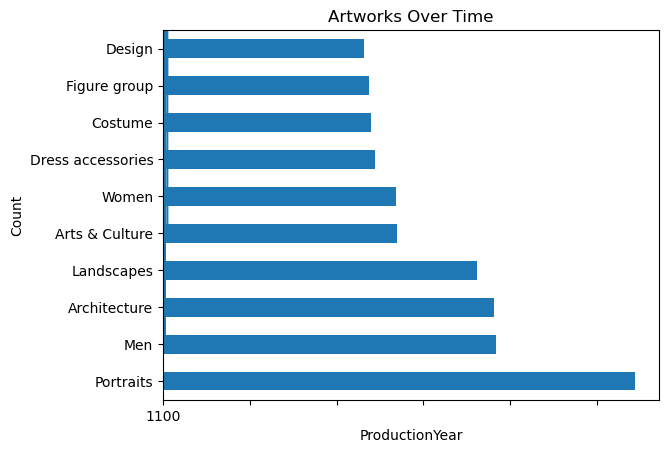

In [9]:
import requests
import json
import pandas as pd
from collections import Counter

API_KEY = os.getenv("SMITHSONIAN_KEY")


def fetch_large_artwork_dataset(api_key, query="art", category="art_design", max_results=50000, batch_size=100):
    """
    Fetches a large dataset of artworks from the Smithsonian API, including production dates and themes.

    Args:
        api_key (str): Your Smithsonian API key.
        query (str): Search query (e.g., "American art").
        category (str): Category to search within (default is "art_design").
        max_results (int): Maximum number of results to fetch.
        batch_size (int): Number of results to fetch per request.

    Returns:
        list: List of dictionaries containing artwork metadata, themes, and production dates.
    """
    all_results = []
    for start in range(0, max_results, batch_size):
        print(f"Fetching records {start} to {start + batch_size}...")
        try:
            rows = category_search(
                q=query,
                category=category,
                start=start,
                rows=batch_size,
                sort="relevancy",
                api_key=api_key,
            )
            if rows is None:
                break
            # Extract relevant fields
            for row in rows:
                content = row.get("content", {})
                indexed_structured = content.get("indexedStructured", {})
                descriptive_non_repeating = content.get("descriptiveNonRepeating", {})
                data = {
                    "id": row.get("id"),
                    "title": row.get("title"),
                    "type": descriptive_non_repeating.get("data_source"),
                    "topic": indexed_structured.get("topic", []),
                    "production_date": indexed_structured.get("date", []),  # Date when artwork was produced
                    "online_media": descriptive_non_repeating.get("online_media"),
                }
                all_results.append(data)
        except Exception as e:
            print(f"Error fetching data: {e}")
            break
        
        # Break loop early if we reach the max results
        if len(all_results) >= max_results:
            break
    
    print(f"Total records fetched: {len(all_results)}")
    return all_results[:max_results]

def save_json(data, filepath):
    """
    Saves data to a JSON file.

    Args:
        data (list): List of dictionaries to save.
        filepath (str): Path to save the JSON file.
    """
    with open(filepath, "w") as f:
        json.dump(data, f, indent=4)
    print(f"Data saved to {filepath}")

def extract_and_visualize_art_data(json_filepath):
    """
    Extracts themes and production dates from JSON data and visualizes them.

    Args:
        json_filepath (str): Path to the JSON file.

    Returns:
        pd.DataFrame: DataFrame with processed artwork data.
    """
    with open(json_filepath, "r") as f:
        data = json.load(f)
    
    # Flatten the data into a DataFrame
    rows = []
    for item in data:
        row = {
            "ID": item.get("id"),
            "Title": item.get("title"),
            "Type": item.get("type"),
            "ProductionDate": ", ".join(item.get("production_date", [])),
            "Topics": ", ".join(item.get("topic", [])),
        }
        rows.append(row)
    df = pd.DataFrame(rows)
    
    # Analyze themes
    all_topics = [topic for sublist in df["Topics"].str.split(", ").dropna() for topic in sublist]
    theme_counts = Counter(all_topics)
    theme_df = pd.DataFrame(theme_counts.items(), columns=["Theme", "Count"]).sort_values(by="Count", ascending=False)
    
    # Visualize top themes
    theme_df.head(10).plot(kind="barh", x="Theme", y="Count", legend=False, title="Top 10 Themes in American Artwork")
    
    # Analyze production dates
    df["ProductionYear"] = df["ProductionDate"].str.extract(r"(\d{4})")  # Extract year from date
    year_counts = df["ProductionYear"].value_counts().sort_index()
    year_counts.plot(kind="line", title="Artworks Over Time", ylabel="Count")
    
    return df

# Fetch artwork data with themes and production dates
artwork_data = fetch_large_artwork_dataset(API_KEY, query="American art", category="art_design", max_results=50000)

# Save data to JSON
json_filepath = "american_artworks_with_dates.json"
save_json(artwork_data, json_filepath)

# Extract and visualize data
artwork_df = extract_and_visualize_art_data(json_filepath)

# Optionally, save to CSV
csv_filepath = "american_artworks_with_dates.csv"
artwork_df.to_csv(csv_filepath, index=False)
print(f"Data saved to {csv_filepath}")


---


Processed data saved as 'theme_counts.csv' and 'yearly_theme_counts.csv'.


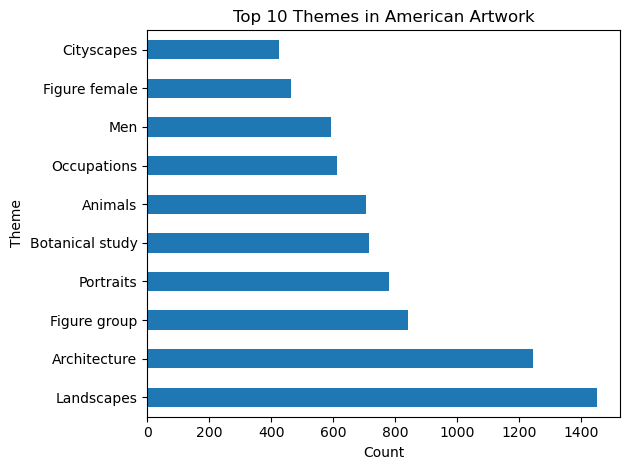

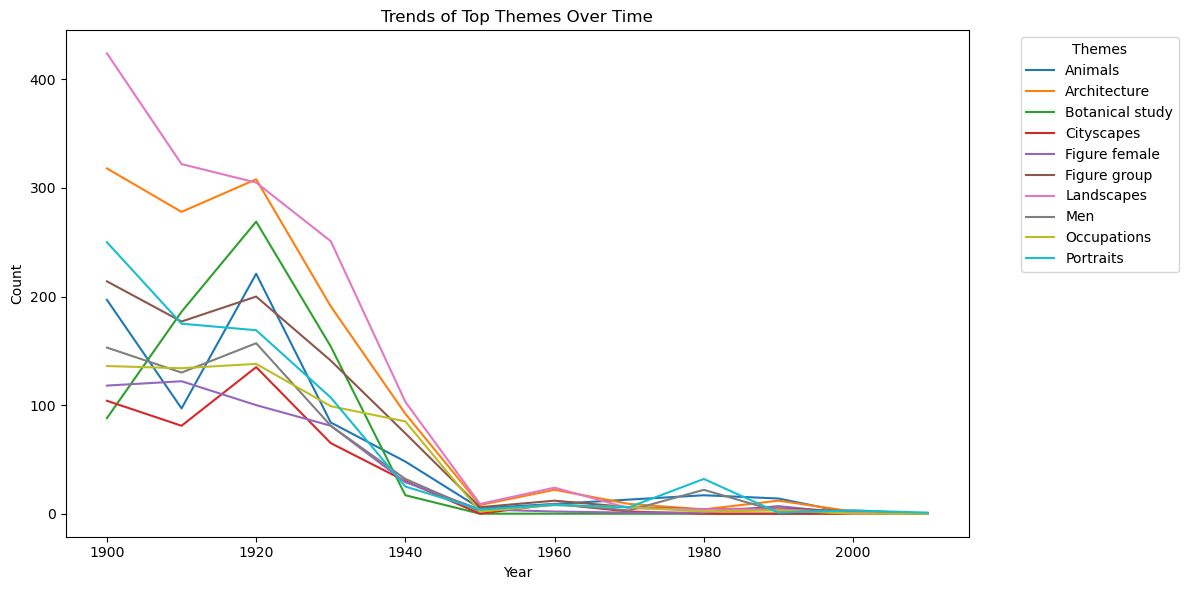

In [16]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Sample JSON file path
json_file_path = "american_artworks_with_dates.json"


def process_data(json_filepath, output_csv_path_base="processed_data"):
    """
    Process JSON data to extract topics and production dates for visualization.
    Filters the data to include only records from 1900 onwards.
    """
    with open(json_filepath, "r") as file:
        data = json.load(file)

    rows = []
    for item in data:
        # Extract production date and topic
        production_dates = item.get("production_date", [])
        topics = item.get("topic", [])
        
        if not production_dates or not topics:
            continue  # Skip if either field is missing
        
        # Process each production date
        for date in production_dates:
            # Convert decades to specific years (e.g., "1870s" -> "1870")
            if "s" in date:
                year = int(date.strip("s"))
            elif date.isdigit():
                year = int(date)
            else:
                continue  # Skip if the format is unrecognized
            
            # Include only years from 1900 onwards
            if year < 1900:
                continue
            
            # Add rows for each topic
            for topic in topics:
                rows.append({"Year": year, "Theme": topic})
    
    if not rows:
        raise ValueError("No valid data could be extracted from the JSON file.")
    
    # Convert to DataFrame
    df = pd.DataFrame(rows)
    
    df.to_csv(f"{output_csv_path_base}_full.csv", index=False)

    # Overall theme counts
    theme_counts = df["Theme"].value_counts().reset_index()
    theme_counts.columns = ["Theme", "Count"]
    
    # Yearly theme counts
    yearly_theme_counts = df.groupby(["Year", "Theme"]).size().reset_index(name="Count")
    
    return df, theme_counts, yearly_theme_counts




def visualize_themes(theme_counts, yearly_theme_counts):
    """
    Visualizes the themes with a bar chart and line chart.
    """
    # Bar chart of most common themes
    top_themes = theme_counts.head(10)
    top_themes.plot(kind="barh", x="Theme", y="Count", legend=False, 
                    title="Top 10 Themes in American Artwork")
    plt.xlabel("Count")
    plt.ylabel("Theme")
    plt.tight_layout()
    plt.show()
    
    # Line chart of theme trends over time
    top_theme_names = top_themes["Theme"].tolist()
    pivot_data = yearly_theme_counts[yearly_theme_counts["Theme"].isin(top_theme_names)]
    pivot_data = pivot_data.pivot(index="Year", columns="Theme", values="Count").fillna(0)
    
    pivot_data.plot(kind="line", title="Trends of Top Themes Over Time", figsize=(12, 6))
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.legend(title="Themes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Run the processing and visualization
try:
    df, theme_counts, yearly_theme_counts = process_data(json_file_path)
    
    # Save processed data to CSV
    theme_counts.to_csv("theme_counts.csv", index=False)
    yearly_theme_counts.to_csv("yearly_theme_counts.csv", index=False)
    print("Processed data saved as 'theme_counts.csv' and 'yearly_theme_counts.csv'.")
    
    # Visualize themes
    visualize_themes(theme_counts, yearly_theme_counts)
except Exception as e:
    print(f"Error: {e}")


Some visualisations to make sense of the data:

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_art_trends(yearly_theme_counts, top_n=10):
    """
    Visualizes trends in art themes over time.
    
    Parameters:
        yearly_theme_counts (pd.DataFrame): DataFrame with yearly theme counts.
        top_n (int): Number of top themes to visualize based on total count.
    """
    # Identify top N themes by overall count
    top_themes = (
        yearly_theme_counts.groupby("Theme")["Count"]
        .sum()
        .nlargest(top_n)
        .index
    )
    
    # Filter the data to include only the top themes
    filtered_data = yearly_theme_counts[yearly_theme_counts["Theme"].isin(top_themes)]
    
    # Set up the plot
    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=filtered_data,
        x="Year",
        y="Count",
        hue="Theme",
        marker="o"
    )
    
    # Customizing the plot
    plt.title("Trends in Art Themes Over Time (1900 Onwards)", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Count of Artworks", fontsize=14)
    plt.legend(title="Theme", title_fontsize=12, fontsize=10, loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

def visualize_theme_distribution(theme_counts, top_n=10):
    """
    Visualizes the distribution of top themes.
    
    Parameters:
        theme_counts (pd.DataFrame): DataFrame with total theme counts.
        top_n (int): Number of top themes to display.
    """
    # Get the top N themes
    top_theme_counts = theme_counts.nlargest(top_n, "Count")
    
    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=top_theme_counts,
        x="Count",
        y="Theme",
        palette="viridis"
    )
    
    # Customizing the plot
    plt.title("Top Art Themes by Total Count", fontsize=16)
    plt.xlabel("Total Count", fontsize=14)
    plt.ylabel("Theme", fontsize=14)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [19]:
print(yearly_theme_counts.head())
print(theme_counts.head())


   Year              Theme  Count
0  1900  A Christmas Carol      1
1  1900             Abbeys      1
2  1900   Academic costume      1
3  1900   Academy of Music      1
4  1900          Accidents      4
             Theme  Count
0       Landscapes   1452
1     Architecture   1244
2     Figure group    841
3        Portraits    781
4  Botanical study    714


Top 10 themes selected: ['Landscapes', 'Architecture', 'Figure group', 'Portraits', 'Botanical study', 'Animals', 'Occupations', 'Men', 'Figure female', 'Cityscapes']


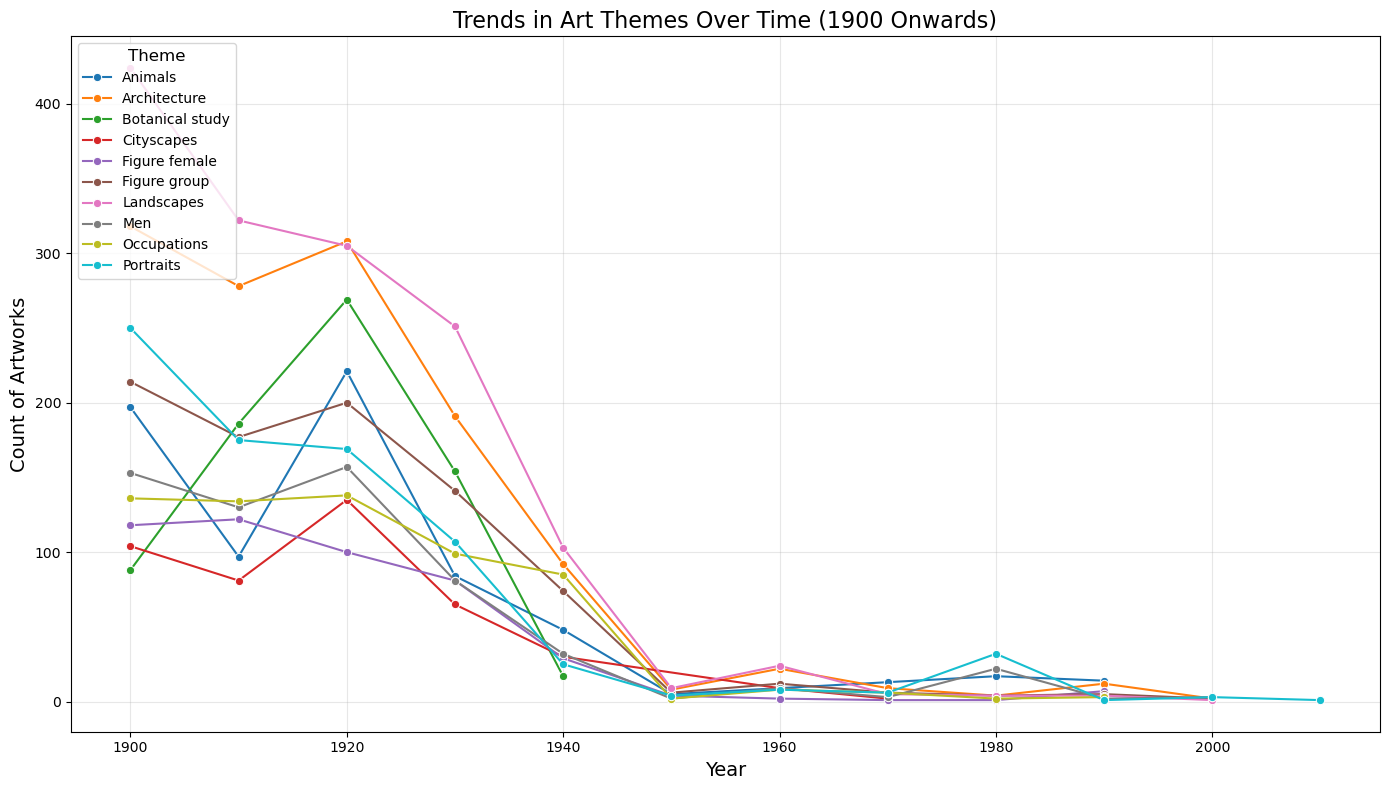

Top 10 themes:
             Theme  Count
0       Landscapes   1452
1     Architecture   1244
2     Figure group    841
3        Portraits    781
4  Botanical study    714
5          Animals    705
6      Occupations    613
7              Men    594
8    Figure female    465
9       Cityscapes    426


/tmp/ipykernel_351/2922292160.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


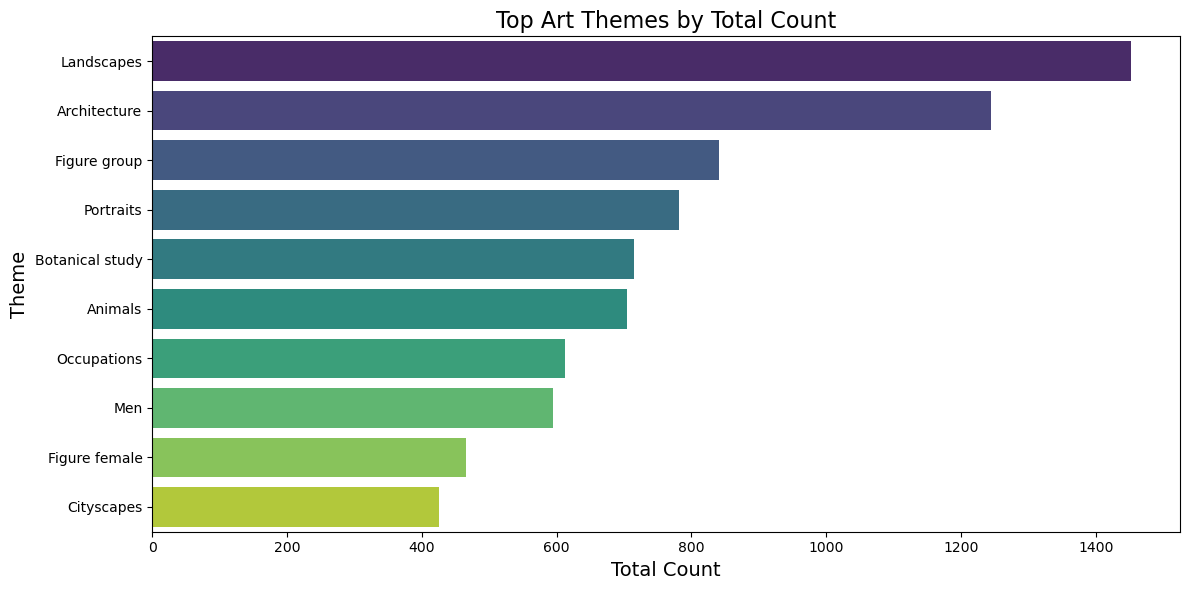

In [20]:
visualize_art_trends(yearly_theme_counts, top_n=10)
visualize_theme_distribution(theme_counts, top_n=10)

    Decade               Theme  Count  Rank
0     1900          Landscapes    424   1.0
1     1900        Architecture    318   2.0
2     1900           Portraits    250   3.0
3     1910          Landscapes    322   1.0
4     1910        Architecture    278   2.0
5     1910     Botanical study    186   3.0
6     1920        Architecture    308   1.0
7     1920          Landscapes    305   2.0
8     1920     Botanical study    269   3.0
9     1930          Landscapes    251   1.0
10    1930        Architecture    191   2.0
11    1930     Botanical study    154   3.0
12    1940          Landscapes    103   1.0
13    1940        Architecture     92   2.0
14    1940         Occupations     85   3.0
15    1950          Landscapes      9   1.0
16    1950        Architecture      8   2.0
17    1950        Figure group      6   3.0
18    1960          Landscapes     24   1.0
19    1960        Architecture     22   2.0
20    1960            Domestic     13   3.0
21    1970             Animals  

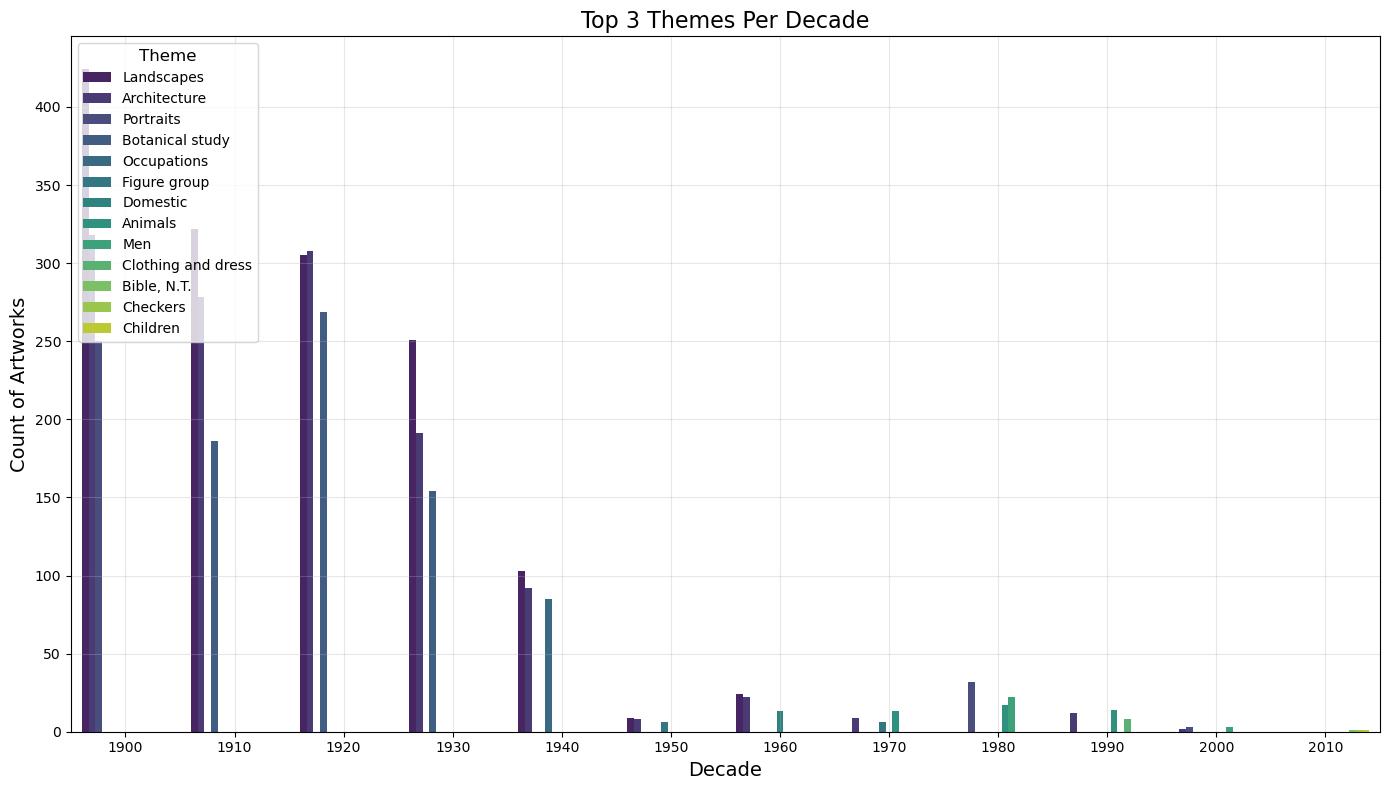

In [22]:
def top_themes_per_decade(yearly_theme_counts):
    """
    Identifies the top 3 themes per decade based on their total count.
    
    Parameters:
        yearly_theme_counts (pd.DataFrame): DataFrame with columns 'Year', 'Theme', and 'Count'.
    
    Returns:
        pd.DataFrame: DataFrame with top 3 themes per decade.
    """
    # Convert Year to int and calculate the Decade
    yearly_theme_counts['Decade'] = (yearly_theme_counts['Year'] // 10) * 10
    
    # Group by Decade and Theme, then sum the counts
    decade_theme_counts = (
        yearly_theme_counts.groupby(['Decade', 'Theme'])['Count']
        .sum()
        .reset_index()
    )
    
    # Rank themes within each decade and select the top 3
    decade_theme_counts['Rank'] = (
        decade_theme_counts.groupby('Decade')['Count']
        .rank(method='first', ascending=False)
    )
    top_themes = decade_theme_counts[decade_theme_counts['Rank'] <= 3]
    
    # Sort the result for better readability
    top_themes = top_themes.sort_values(by=['Decade', 'Rank']).reset_index(drop=True)
    
    return top_themes

# Call the function
top_themes = top_themes_per_decade(yearly_theme_counts)

# Display the result
print(top_themes)

# Save to CSV for further inspection if needed
top_themes.to_csv("top_themes_per_decade.csv", index=False)


def visualize_top_themes_per_decade(top_themes):
    """
    Visualizes the top 3 themes per decade as a bar plot.
    
    Parameters:
        top_themes (pd.DataFrame): DataFrame with columns 'Decade', 'Theme', 'Count', and 'Rank'.
    """
    # Set up the plot
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=top_themes,
        x="Decade",
        y="Count",
        hue="Theme",
        palette="viridis"
    )
    
    # Customizing the plot
    plt.title("Top 3 Themes Per Decade", fontsize=16)
    plt.xlabel("Decade", fontsize=14)
    plt.ylabel("Count of Artworks", fontsize=14)
    plt.legend(title="Theme", title_fontsize=12, fontsize=10, loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Call the visualization
visualize_top_themes_per_decade(top_themes)
